In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score 
from dataFrameCovid import DataFrameCovid as dfc
from sklearn.metrics import classification_report
from geraArquivo1 import GeraArquivo as ga

In [2]:
# Monta dataframe com nome dos arquivos
df = dfc.getDf()

d:\DropB\Faculeste\TCC\codigos\dataFrameCovid.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [3]:
len(df)

6800

In [4]:
# Variáveis de controle
nImagens = len(df)
percentual = 0.8
tamanhoDoLote = 200
epocas = 50
passosPorEpoca = int(nImagens*percentual // tamanhoDoLote)
passosPorValidacao = int(nImagens*(1.0 - percentual) // tamanhoDoLote)
width = 32
height = 32
depth = 3
classes = 2
inputShape = (height, width, depth)
passosPorEpoca, passosPorValidacao

(27, 6)

In [5]:
# gerando dataframes de treinamento e de teste
dfTreinamento = df.sample(frac=0.8, random_state=100) # 80% de treinamento
dfTeste = df[~df['arquivo'].isin(dfTreinamento['arquivo'])]     # 20% de Validação

In [6]:
imgGen = ImageDataGenerator(rescale = 1./255, 
                            shear_range=0.25, 
                            zoom_range = 0.25, 
                            horizontal_flip = True)

conjTreinamento = imgGen.flow_from_dataframe(dfTreinamento, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

conjTeste = imgGen.flow_from_dataframe(dfTeste, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

Found 5440 validated image filenames belonging to 2 classes.
Found 1360 validated image filenames belonging to 2 classes.


In [7]:
# ShallowNet - Ajustar imagens para 32 x 32
from modShallowNet import ShallowNet
shlwClf = ShallowNet()
shlwClf = shlwClf.build(width=width, height=height, depth=3, classes=2)
shlwClf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 2)                 65538     
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 66,434
Trainable params: 66,434
Non-trainable params: 0
_________________________________________________________________


c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
print("Shallow Net ***************************************************")
h1 = shlwClf.fit(x=conjTreinamento, steps_per_epoch=passosPorEpoca, epochs=epocas, validation_data=conjTeste, validation_steps=passosPorValidacao, verbose=1).history

Shallow Net ***************************************************
Epoch 1/50
27/27 [==============================] - 17s 626ms/step - loss: 1.0176 - accuracy: 0.5685 - val_loss: 0.6775 - val_accuracy: 0.5942
Epoch 2/50
27/27 [==============================] - 16s 615ms/step - loss: 0.6471 - accuracy: 0.6298 - val_loss: 0.6157 - val_accuracy: 0.6558
Epoch 3/50
27/27 [==============================] - 16s 606ms/step - loss: 0.6165 - accuracy: 0.6622 - val_loss: 0.7093 - val_accuracy: 0.5900
Epoch 4/50
27/27 [==============================] - 17s 616ms/step - loss: 0.6190 - accuracy: 0.6517 - val_loss: 0.6519 - val_accuracy: 0.6108
Epoch 5/50
27/27 [==============================] - 16s 590ms/step - loss: 0.6233 - accuracy: 0.6444 - val_loss: 0.6275 - val_accuracy: 0.6575
Epoch 6/50
27/27 [==============================] - 16s 580ms/step - loss: 0.6406 - accuracy: 0.6336 - val_loss: 0.6473 - val_accuracy: 0.6192
Epoch 7/50
27/27 [==============================] - 16s 580ms/step - loss: 0.6

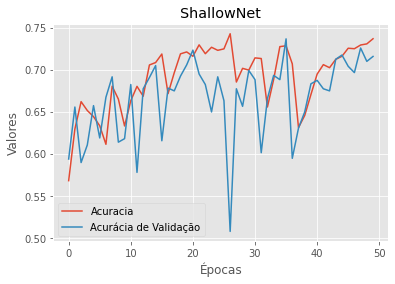

In [9]:
# Gráfico de Acurácia
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epocas), h1["accuracy"], label="Acuracia")
#plt.plot(np.arange(0, epc), h1["loss"], label="Perda")
plt.plot(np.arange(0, epocas), h1["val_accuracy"], label="Acurácia de Validação")
#plt.plot(np.arange(0, epc), h1["val_loss"], label="Perda na Validação")
plt.title("ShallowNet")
plt.xlabel("Épocas")
plt.ylabel("Valores")
plt.legend()
plt.show()

In [10]:
prdSlhw = shlwClf.predict(conjTeste[0][0])
categorias = []
for i in conjTeste[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
predShallow = []
for i in prdSlhw:
    predShallow.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, predShallow, target_names=["Não Covid", "Covid"]))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

   Não Covid       0.82      0.68      0.74       112
       Covid       0.66      0.81      0.73        88

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.75      0.73      0.74       200



In [11]:
ga.geraHistorico("arquivos/arqShallowNet"+str(epocas)+".csv", h1)
ga.geraPredicao("arquivos/arqPredShallow"+str(tamanhoDoLote)+".csv", categorias, predShallow)

In [12]:
''' 
df1 = dfc.getDfPredicao()
prdTmnh = len(df1)
conjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                x_col = 'arquivo',
                                y_col = 'categoria',
                                target_size=(width, height), 
                                batch_size=prdTmnh, 
                                class_mode='categorical')
prdSlhw = shlwClf.predict(conjPred[0][0])
categorias = []
for i in conjPred[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
prdShllw = []
for i in prdSlhw:
    prdShllw.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, prdShllw, target_names=["Não Covid", "Covid"]))
'''

' \ndf1 = dfc.getDfPredicao()\nprdTmnh = len(df1)\nconjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", \n                                x_col = \'arquivo\',\n                                y_col = \'categoria\',\n                                target_size=(width, height), \n                                batch_size=prdTmnh, \n                                class_mode=\'categorical\')\nprdSlhw = shlwClf.predict(conjPred[0][0])\ncategorias = []\nfor i in conjPred[0][1]:\n    categorias.append(0 if i[0] > 0.0 else 1)\nprdShllw = []\nfor i in prdSlhw:\n    prdShllw.append(0 if i[0] >= 0.5 else 1)\nprint(classification_report(categorias, prdShllw, target_names=["Não Covid", "Covid"]))\n'